## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [10]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        print(input_shape)
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, int(input_shape/2)),
            nn.BatchNorm1d(int(input_shape/2)),
            nn.LeakyReLU(),
            nn.Linear(int(input_shape/2), 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [11]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28, ))

784
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
       BatchNorm1d-3                  [-1, 392]             784
         LeakyReLU-4                  [-1, 392]               0
            Linear-5                  [-1, 128]          50,304
       BatchNorm1d-6                  [-1, 128]             256
         LeakyReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
           Softmax-9                   [-1, 10]               0
Total params: 360,354
Trainable params: 360,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.37
Estimated Total Size (MB): 1.40
---------------------------------------

Your experiments come here:

In [44]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_func = nn.CrossEntropyLoss()

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    size_batch = len(dataloader)
    model.train()
    loss_it = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_it += loss.item()
        if batch %100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_it / size_batch

def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    clear_output(wait=True)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_func, opt, device)
    test_loop(test_loader, model, loss_func, device)
print("Done!")
# Your experiments, training and validation loops here

Test Error: 
 Accuracy: 86.7%, Avg loss: 1.595236 

Done!


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [45]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, int(input_shape)),
            nn.ReLU(),
            nn.Linear(int(input_shape), int(input_shape)),
            nn.ReLU(),
            nn.Linear(int(input_shape), num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [48]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 784]         615,440
              ReLU-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
           Softmax-7                   [-1, 10]               0
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.73
Estimated Total Size (MB): 4.76
----------------------------------------------------------------


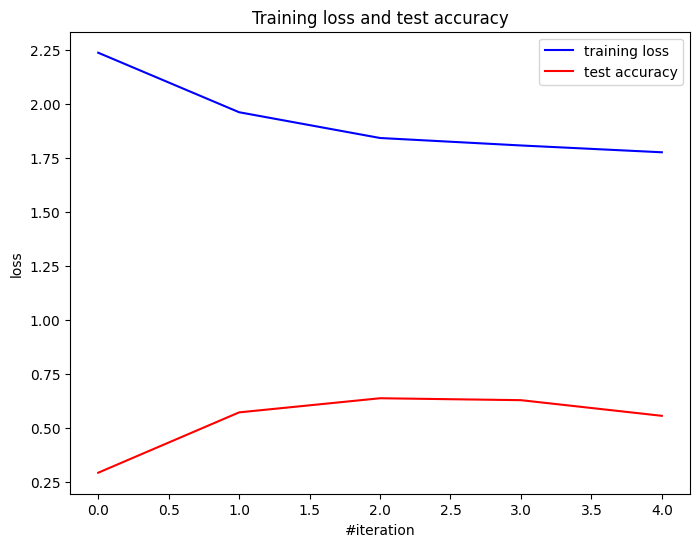

Done!


In [49]:
model = OverfittingNeuralNetwork().to(device)
# increase lr for force overfitting
opt = torch.optim.SGD(model.parameters(), lr=5e-1)
loss_func = nn.CrossEntropyLoss()

train_loader_small = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_dataset_train, torch.arange(5000)), 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
epochs = 5
loss = []
accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss.append(train_loop(train_loader_small, model, loss_func, opt, device))
    accuracy.append(test_loop(test_loader, model, loss_func, device))

clear_output(wait=False)
plt.figure(figsize=(8, 6))
plt.title("Training loss and test accuracy")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss, 'b', label='training loss')
plt.plot(accuracy, 'r', label='test accuracy')
plt.legend()
plt.show()
print("Done!")

# We see that training loss decreases and test accuracy decreases it's overfitting 

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [50]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, int(input_shape)),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(int(input_shape)),
            nn.ReLU(),
            nn.Linear(int(input_shape), int(input_shape)),
            nn.Dropout(p=0.3),
            nn.BatchNorm1d(int(input_shape)),
            nn.ReLU(),
            nn.Linear(int(input_shape), num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [51]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
           Dropout-3                  [-1, 784]               0
       BatchNorm1d-4                  [-1, 784]           1,568
              ReLU-5                  [-1, 784]               0
            Linear-6                  [-1, 784]         615,440
           Dropout-7                  [-1, 784]               0
       BatchNorm1d-8                  [-1, 784]           1,568
              ReLU-9                  [-1, 784]               0
           Linear-10                   [-1, 10]           7,850
          Softmax-11                   [-1, 10]               0
Total params: 1,241,866
Trainable params: 1,241,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

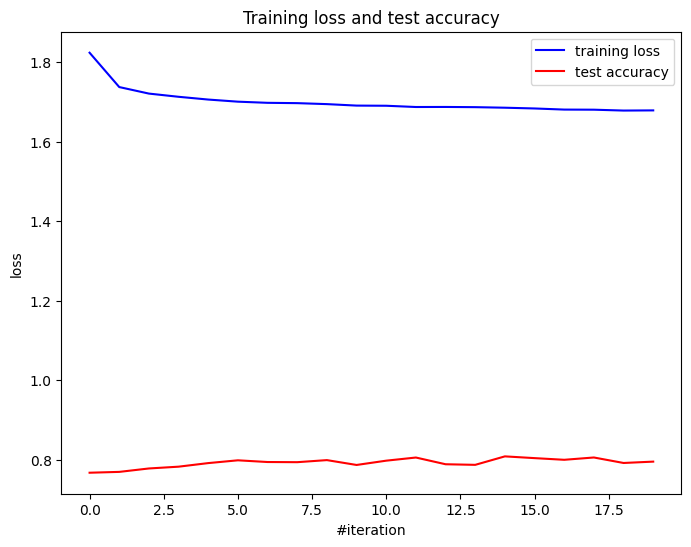

Done!


In [52]:
model = FixedNeuralNetwork().to(device)

opt = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_func = nn.CrossEntropyLoss()

# safe from overfitting
train_transform_overfitting = transforms.Compose([
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomResizedCrop(size=(28, 28), scale=(0.7, 1.1)),
                              transforms.ToTensor(),
])
fmnist_dataset_train_fixed = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform_overfitting,
                                                        target_transform=None,
                                                        download=download)
train_loader_fixed = torch.utils.data.DataLoader(fmnist_dataset_train_fixed, 
                                                       batch_size=128,
                                                       shuffle=True,
                                                       num_workers=2)
# Your experiments, come here
epochs = 20
loss = []
accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss.append(train_loop(train_loader_fixed, model, loss_func, opt, device))
    accuracy.append(test_loop(test_loader, model, loss_func, device))

clear_output(wait=False)
plt.figure(figsize=(8, 6))
plt.title("Training loss and test accuracy")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss, 'b', label='training loss')
plt.plot(accuracy, 'r', label='test accuracy')
plt.legend()
plt.show()
print("Done!")

# We see that dropout, augmentation save us from overfitting accuracy doesn't decrease

### Conclusions:
_Write down small report with your conclusions and your ideas._
## Dropout, batchNorm and augmentation good for saving from overfitting, you must use it for your good nn